<a href="https://colab.research.google.com/github/elhamkashi/DSPS_EKashi/blob/main/HW6%5CSecond_Half_fitlinetogrbafterglow_mcmc_dsps25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [18]:
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pylab as plt
# you will need more imports, put them here
from scipy.optimize import minimize

# HW part 1

## Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [19]:
# data is called grb050525A.csv in the data folder in the DSPS_FBianco repo
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/refs/heads/main/data/grb050525A.csv")
grbAG.head()


,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


The term upper limit (meaning the flux is below this value, or the magnitude is above this value, since faint = large magnitude).

In [ ]:
# What grbAG["filter"].unique() returns:
#array ['V', 'R', 'B']


In [ ]:
pl.arrow(grbAG.loc[i].time,      # x-start: time of observation
         grbAG.loc[i].mag,       # y-start: upper limit magnitude value
         0,                      # dx: horizontal change (0 = straight vertical)
         0.5,                    # dy: vertical change (points upward)
         head_width=1e4,         # width of arrowhead
         overhang=1,             # how much arrowhead overlaps shaft
         shape="full",           # complete arrowhead shape
         head_length=0.1,        # length of arrowhead
         ec='#555555',           # edge color: dark gray
         visible=True)           # make sure arrow is visible

NameError: name 'i' is not defined

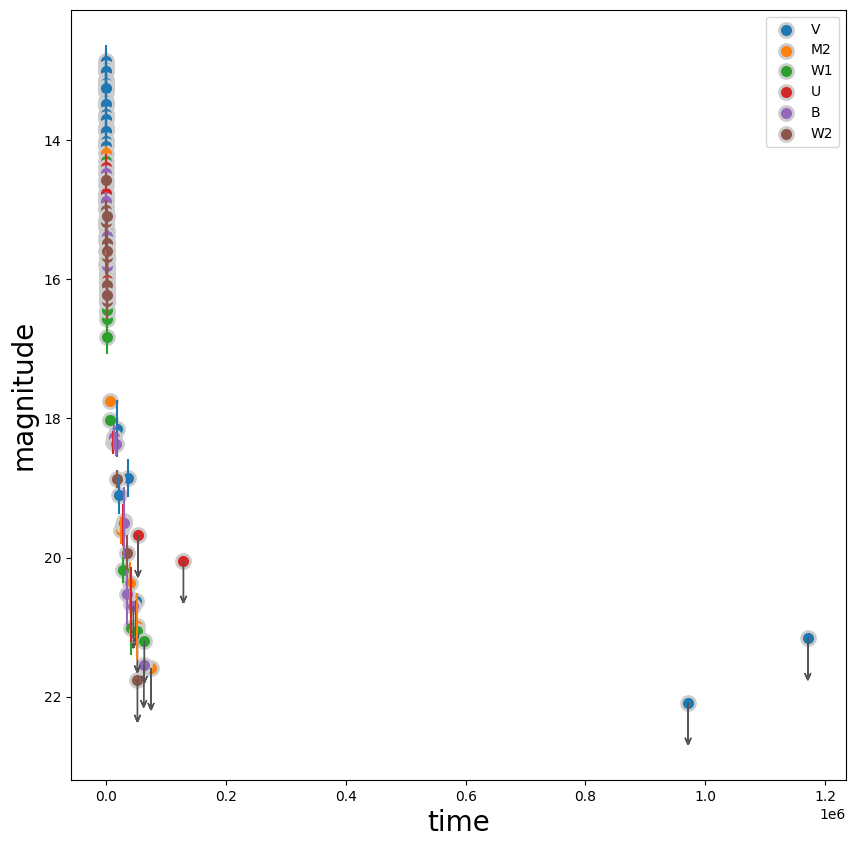

In [20]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111) #1row, 1column, 1 index

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

#pl.errorbar(x_values, y_values, yerr=error_values)
for f in grbAG["filter"].unique():  #Go through each unique filter in the dataset, one at a time, and plot that subset.
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],   #DataFrame.loc[rows, columns]
                grbAG.loc[grbAG["filter"] == f, "mag"],# Select only rows where filter == "f" and get the "mag" column
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], #Create a new variable named yerr, and store inside it the column magerr for the current filter.
                fmt='.', ms=0, #fomating string=Plot each data point as a dot (no connecting line), markersize=don’t show a visible marker, only show error bars
                fcolor=None, label=None) #no label added to legend

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')  #'#cccccc'???


# plot the upperlimits as arrows, nuplim =number of data points
nuplim = grbAG.mag.isna().sum() #the total number of missing magnitude entries.
for i in grbAG[grbAG.upperlimit == 1].index: #“For every index i that corresponds to an upper-limit observation, draw an arrow.”
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
#pl.ylim(24,11.7) #simpler, less elegant - still does the trick
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

## Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [21]:
grbAG["logtime"] = np.log10(grbAG["time"])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


## Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [24]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

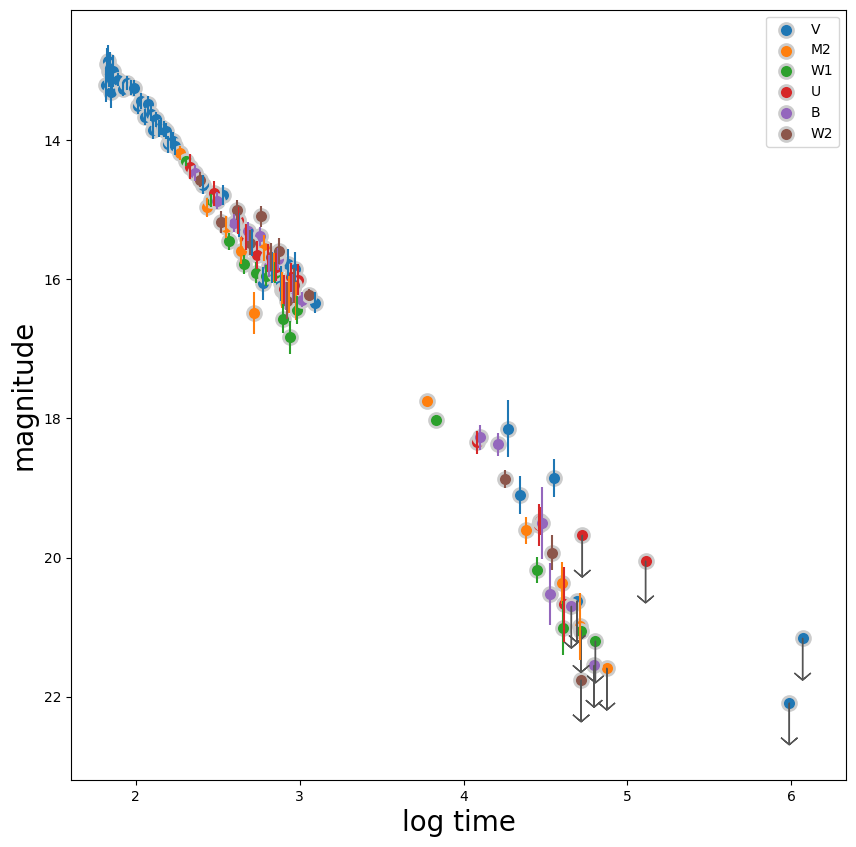

In [ ]:
plotlogtime(grbAG);

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

## Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [25]:
grbAGnouplim =  grbAG[grbAG["upperlimit"] == 0]# remove the upper limits from the dataframe to simplify the analysis

In [26]:
x = grbAGnouplim.logtime.values  #grbAGnouplim.logtime → this is a column that stores log t, x is the independent variable
                                  #.values → extracts the column as a NumPy array (not a pandas Series).
#pick a function to expand the axis and the design matrix X for the normal equation.

#option 1
X = np.c_[np.ones((len(grbAGnouplim), 1)),x]
#option 2 np.dstack((np.ones((X.shape[0])) ,X))


y = grbAGnouplim.mag.values
print("shape of the input array X", X.shape) #X.shape → (N, 2),(N data points, and 2 columns = [constant term, log(time)])
print("shape of the input array y", y.shape)# array of magnitudes =N
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [ ]:
#np.linalg.inv() = matrix inverse
#.dot() = matrix multiplication
#θ (theta) = [ slope, intercept]= the parameter vector
#intercept → the magnitude when logt=0 i.e t=1
#*theta_best is a Python unpacking operator
#format(*theta_best) means “insert both numbers from theta_best — the intercept and slope — into the text string, each shown with two decimal places :.2.

In [27]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
# The order of parameters is now slope and then intercept
print ("best fit parameters from the Normal Equation: " +
       "slope {:.2f}, intercept {:.2f}".format(theta_best[1], theta_best[0]))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


Now the notebook switches to a different method — sklearn

The previous part (the “Normal Equation”) did everything manually with NumPy linear algebra.

This is a new section (“## Fit a line to the data (excluding the upper limits) with sklearn LinearRegression”), using the original full dataset grbAG again, not grbAGnouplim




In [ ]:
# grbAGnouplim = grbAG[grbAG["upperlimit"] == 0] and grbAG.loc[grbAG.upperlimit == 0] do the same

## Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [81]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
lr = LinearRegression()
lr.fit(X, y)
print(f"slope {lr.coef_[1]:.2f} and intercept {lr.intercept_:.2f}")

slope 2.51 and intercept 8.58


## Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [86]:
#note: imports should be moved to the top cell - follow PEP8 guidelines


def line( slope, intercept, x):
    '''returns a line
    args:
    intercept: float
    slope: float
    x: array-like of exogenous variables
    '''
    return slope * x+intercept

def l1(args, x, y):
    '''l1 target function: returns value of l1 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L1 abs value of difference between prediction and data squared
    '''
    a, b = args
    return np.sum(np.abs(line(a, b, x) - y))


initialGuess = (2, 8)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.304418414643912
        x: [ 2.640e+00  8.228e+00]
      nit: 6
      jac: [ 1.599e-01  0.000e+00]
 hess_inv: [[ 3.546e-04 -9.644e-04]
            [-9.644e-04  3.977e-03]]
     nfev: 189
     njev: 59

best fit parameters from the minimization of L1: slope 2.64, intercept 8.23


In [87]:

def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    a, b = args
    return np.sum((line(a, b, x) - y)**2)


initialGuess = (2, 8)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.825987500725514
        x: [ 2.512e+00  8.583e+00]
      nit: 4
      jac: [ 1.192e-07  3.576e-07]
 hess_inv: [[ 7.114e-03 -2.030e-02]
            [-2.030e-02  6.254e-02]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of L2: slope 2.51, intercept 8.58


In [ ]:
l2?

In [ ]:
l1?

## Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [88]:
def chi2(args, x, y, s):
    a, b = args
    return np.sum((line(a, b, x) - y)**2 / s**2)


x = grbAGnouplim.logtime.values
y = grbAGnouplim.mag.values
s = grbAGnouplim.magerr.values

initialGuess =  2, 8

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 317.4206698013019
        x: [ 2.480e+00  8.599e+00]
      nit: 6
      jac: [ 1.259e-04  7.629e-06]
 hess_inv: [[ 2.569e-05 -4.223e-05]
            [-4.223e-05  1.395e-04]]
     nfev: 215
     njev: 67

best fit parameters from the minimization of the chi squared: slope 2.48, intercept 8.60


## Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


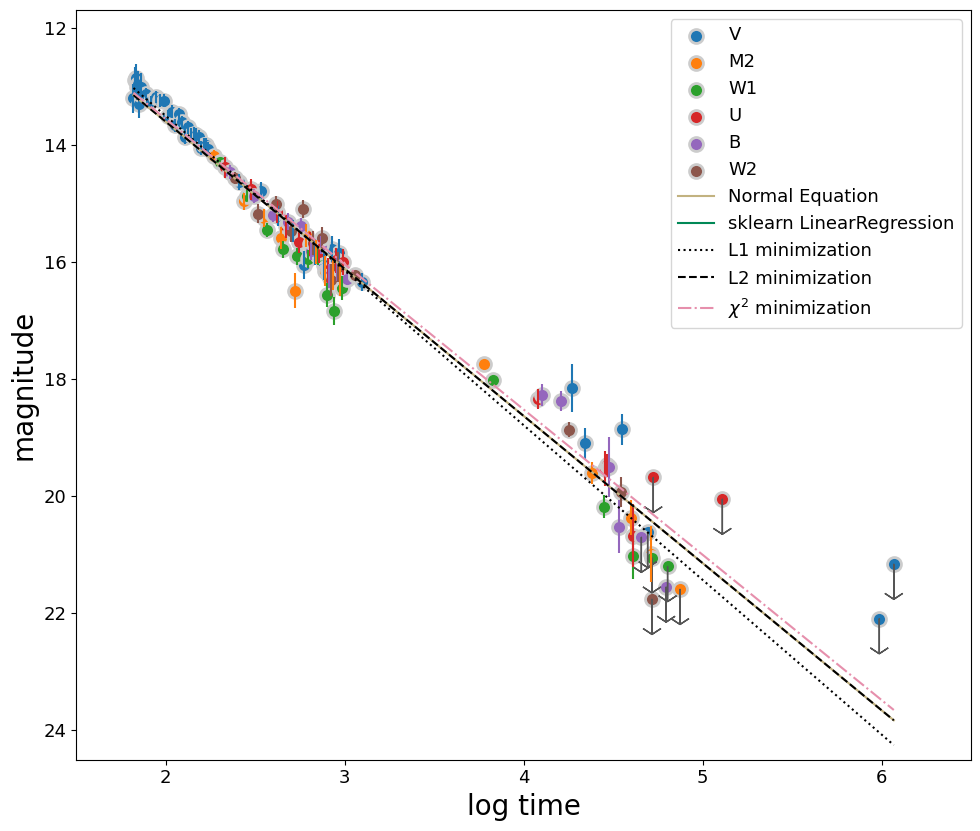

In [91]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(slope, intercept, x) # Corrected order of arguments for line function
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[1], theta_best[0]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[0], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x[0], l1Solution.x[1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[0], l2Solution.x[1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[0], chi2Solution.x[1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);



# Add caption below the figure
#caption_text = "This figure compares linear regression models fitted using different optimization methods\n" \
             #  "on gamma-ray burst afterglow data. What's noticeable is how the various methods (Normal Equation,\n" \
             #  "sklearn, L1/L2 minimization, and chi-squared) produce slightly different slope and intercept\n" \
              # "parameters, resulting in divergent model predictions especially at the extremes of the time range."



# Position caption well below the plot
#pl.figtext(0.5, -0.01, caption_text, ha='center', fontsize=12,
           #bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

# Use tight_layout with explicit bottom padding
pl.tight_layout(rect=[0, 0.1, 1, 0.95])  # [left, bottom, right, top]

# RERWITE THIS CAPTION!

This figure compares linear regression models fitted using different optimization methods
               on gamma-ray burst afterglow data. What's noticeable is how the various methods (Normal Equation
               sklearn, L1/L2 minimization, and chi-squared) produce slightly different slope and intercept
               parameters, resulting in divergent model predictions especially at the extremes of the time range. At early prids of time, higher amount of data are fitted with these line models, however, in later time, the data pattern changes slightly and are scattered around these lines and is not fitted by the current slope range around 2.51!  Another intersting thing, is the time interval (~ 3-4 in logtime)  between these two slope patterns, such that just after the perfect fitting, for a sensible amount of time, there is no observed data, and after this time, scattered data happens.

              


# HW part 2: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((91, 2), (91,), (17, 2), (17,))

In [93]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(f"score on the training set {lr.score(X_train, y_train):.2f}")
print(f"score on the training set {lr.score(X_test, y_test):.2f}")

score on the training set 0.97
score on the training set 0.97


The score is the same for the training and test set. This means that we are not overfitting the data and the model is transferable to unseen data. Furthermore the score is high: the model explains 97% of the variance which is remarkably good!

# Now try a line to the data with MCMC

# HW part 3: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



In [48]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

In [49]:
import emcee #import the package - please move this to the top with the other imports!

In [50]:
emcee

<module 'emcee' from '/usr/local/lib/python3.12/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters:

$P(\theta | D) ∝   P(D | \theta) * P(\theta)$

or

_Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



# Below i develop the line model and find the posterior with MCMC. Your task is to do the same for a different model. the Broken Power Law

In [105]:
# LINE MODEL
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf


In [106]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line( slope, intercept, x))**2) / yerr**2)

In [107]:
#log posterior
def log_posterior(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [108]:
#initial guess
ig = [1,10]

In [109]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [110]:
#the starting point for each walker is a small perturbation of the initial guess
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

In [111]:
pos.shape

(32, 2)

In [112]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

In [113]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 1_000, progress=True); #progress=True show the dynamic percentage bar

100%|██████████| 1000/1000 [00:01<00:00, 896.53it/s]


In [114]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [115]:
samples.shape

(1000, 32, 2)

In [116]:
samples.transpose(1,0,2)[:,:,0].shape

(32, 1000)

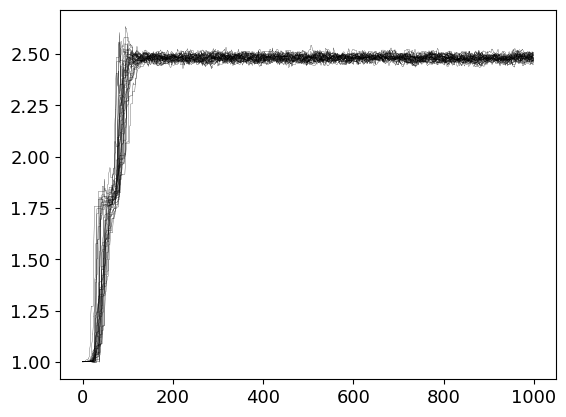

In [117]:
for i in range(ndim):
    pl.plot(samples[:,:,0], 'k', lw=0.1, )

This trace plot serves as a diagnostic check to verify that the MCMC algorithm is working properly for the GRB afterglow model. Each line represents how one walker’s estimate of a model parameter evolves through the sampling process. The fact that all traces start from different values but quickly stabilize and fluctuate around constant levels indicates that the chains have converged. This means the MCMC has successfully explored the parameter space and is now sampling from the true posterior distribution, making the resulting parameter estimates for the GRB afterglow reliable and trustworthy.

to get statistical properties of the chains I will concatenate the 32 chains.
This works _iff_ the chains are independent - see about it in the slides!

note: the chains are _assumed_ to be independent


the first 100 points are where the chains are "burning in" and we will throw them away (`discard=100`) - see slides!!
`flat=True` does the concatenation


In [118]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian


In [144]:
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile(flat_samples[:,i], [16, 50, 84])

print(f"slope {mcmc[0][1]:.2f} [{mcmc[0][0]:.2f}-{mcmc[0][2]:.2f}]")
print(f"intercept {mcmc[1][1]:.2f} [{mcmc[1][0]:.2f}-{mcmc[1][2]:.2f}]")

slope 2.48 [2.47-2.49]
intercept 8.60 [8.56-8.64]


plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters


In [145]:
!pip install corner


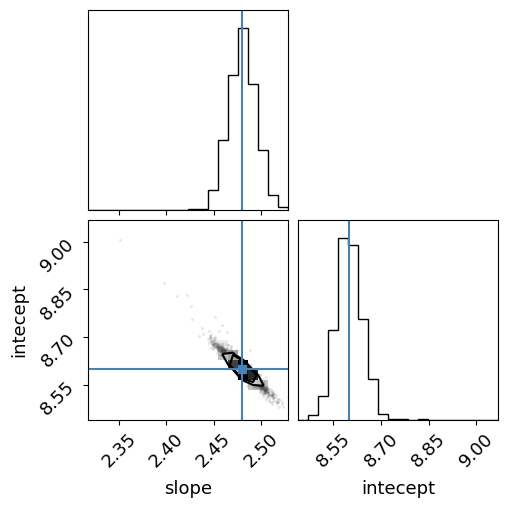

In [146]:
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=[ "slope", "intecept"], truths=mcmc[:,1]);


This Corner plot shows the posterior distributions of the slope and intercept obtained from MCMC sampling. The distributions are narrow with good convergence and small parameter uncertainties. The diagonal panels display 1D histograms of each parameter's marginal posterior distribution, while the off-diagonal panel shows the 2D joint posterior distribution revealing parameter correlations. A mild negative correlation between slope and intercept is visible, and the blue lines marking the true values lie at the peaks of the posteriors, confirming that the MCMC fit is stable and consistent with the best-fit solution.

WRITE YOUR OWN CAPTION HERE!

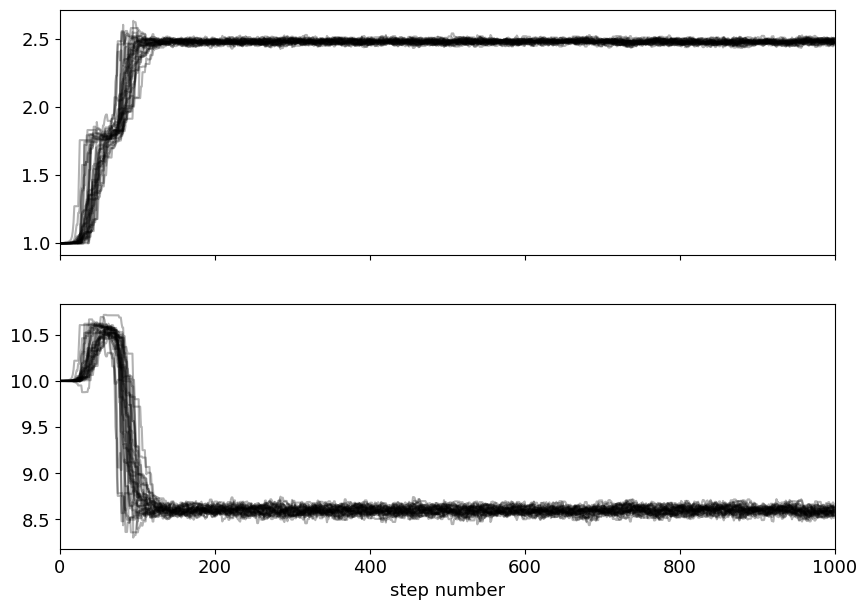

In [125]:
# the chains should be plotted as well. here is a better plot of the chains
#in the slides and in class I discussed what you should expect them to look like
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

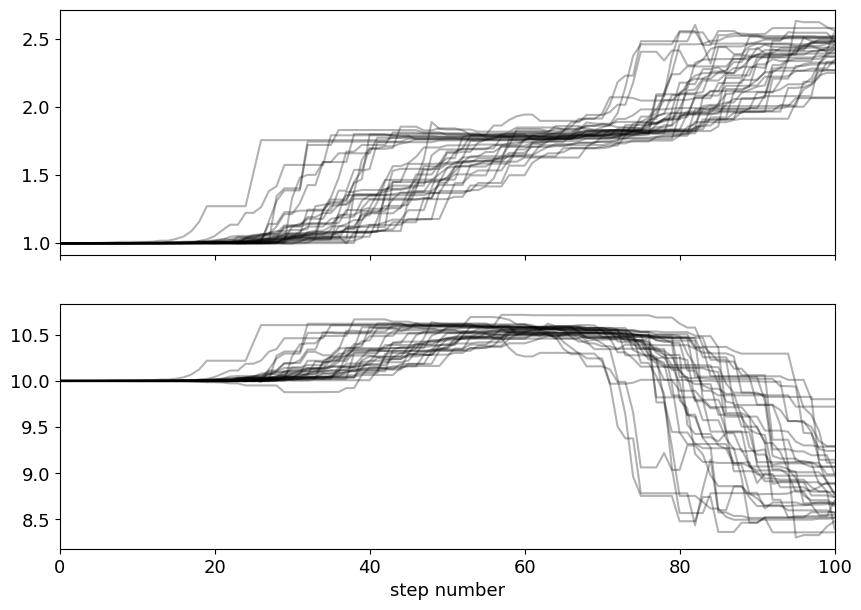

In [126]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [127]:
# save the mcmc results for later
mcmc_line = mcmc
mcmc_line

array([[2.46564906, 2.4801182 , 2.49475345],
       [8.56115002, 8.59809691, 8.64019299]])

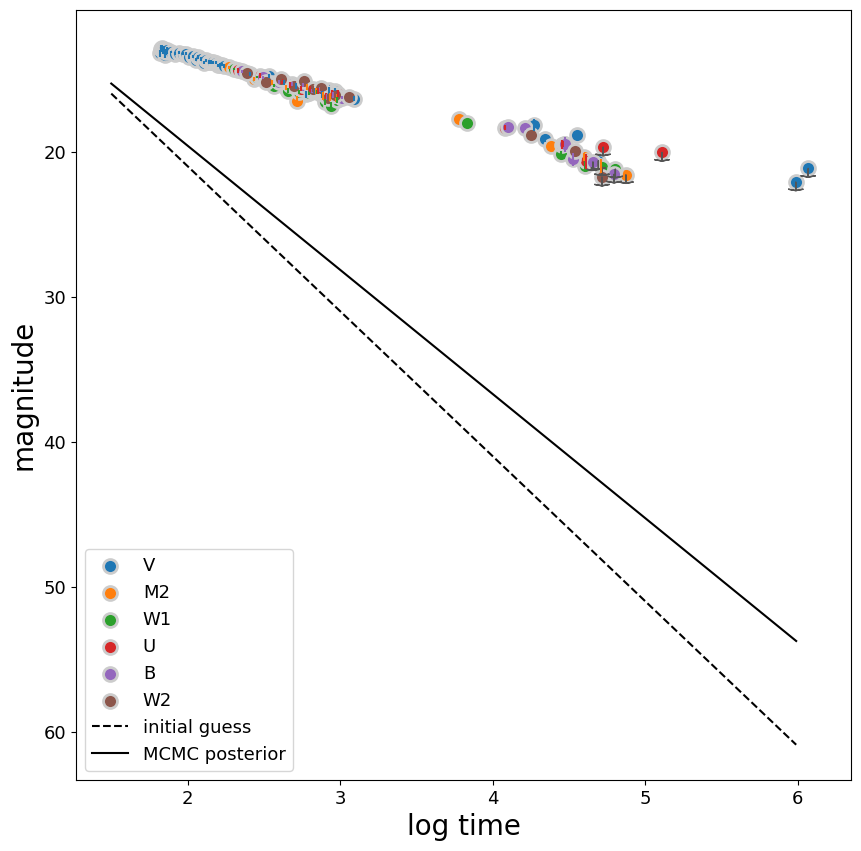

In [128]:
labels = ["slope", "intercept"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(np.arange(1.5,6,0.01),
        line(10, 1, (np.arange(1.5,6,0.01))),
        #line(ig[1], ig[0], 10**np.arange(1.5,6,0.01)),
        ls="--", c="k",
        label="initial guess")

ax.plot(np.arange(1.5,6,0.01),
        line(mcmc_line[1][0], mcmc_line[0][0], np.arange(1.5,6,0.01)),
        ls="-", c="k",
        label="MCMC posterior")

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

#pl.ylim(24.5,11.7)
#pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

# HW part 3

# Now try a broken power law (BPL) model

A power la is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

in flux space the BPL model is:
$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$

in magnitude space (the data you want to predict is in magnitude and the equation is simple to minimize in log space) that is:

$mag = b - log_{10}\left((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2})\right) $



In [129]:
# HW part 3 task 1: MCMC for Broken Power Law (BPL) model from AI

# Define the broken power law model
def broken_power_law(x, a1, a2, x_b, y_b):
    """
    Broken power law model for GRB afterglow in magnitude space
    mag = y_b - log10(((x / x_b)**(-a1) + (x / x_b)**(-a2)))
    x is time (not log time)
    """
    # Add a small epsilon to x and x_b to avoid division by zero or log of zero
    epsilon = 1e-10
    return y_b - np.log10(((x + epsilon) / (x_b + epsilon))**(-a1) + ((x + epsilon) / (x_b + epsilon))**(-a2))


# Define the log likelihood function for BPL
def log_likelihood_bpl(params, x, y, yerr):
    """
    Log likelihood function for broken power law
    """
    a1, a2, x_b, y_b = params
    bpl_model = broken_power_law(x, a1, a2, x_b, y_b)
    sigma2 = yerr**2
    # Add a small epsilon to sigma2 to avoid division by zero
    sigma2 += 1e-10
    return -0.5 * np.sum((y - bpl_model)**2 / sigma2 + np.log(sigma2))

# Define the log prior function for BPL
def log_prior_bpl(params):
    """
    Prior distributions for broken power law parameters
    Using physically reasonable ranges for GRB afterglows
    """
    a1, a2, x_b, y_b = params

    # Priors based on GRB afterglow physics
    if not (0.5 < a1 < 3.0):    # Pre-break slope range
        return -np.inf
    if not (1.0 < a2 < 4.0):    # Post-break slope range
        return -np.inf
    # Break time in log-space (1000-100000 seconds) -> log10(1000) = 3, log10(100000) = 5
    if not (3.0 < np.log10(x_b) < 5.0):
        return -np.inf
    if not (10.0 < y_b < 20.0): # Break magnitude range
        return -np.inf

    return 0.0

# Define the log probability function for BPL
def log_probability_bpl(params, x, y, yerr):
    """
    Log probability function (prior * likelihood)
    """
    lp = log_prior_bpl(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_bpl(params, x, y, yerr)

# Prepare data for MCMC
x_data = grbAGnouplim['time'].values
y_data = grbAGnouplim['mag'].values
y_err = grbAGnouplim['magerr'].values

# Set up MCMC parameters for BPL
ndim_bpl = 4  # a1, a2, x_b, y_b
nwalkers_bpl = 32
nsteps_bpl = 3000

# Initial guesses for BPL parameters based on GRB afterglow typical values
# a1 ~ pre-break slope, a2 ~ post-break slope, x_b ~ break time, y_b ~ break magnitude
initial_guess_bpl = np.array([1.0, 2.0, 10**4.0, 15.0])  # Typical values for GRB afterglows, x_b in linear time

# Starting positions for walkers
starting_positions_bpl = initial_guess_bpl + 0.1 * np.random.randn(nwalkers_bpl, ndim_bpl)

print("Starting MCMC sampling for Broken Power Law model...")
print(f"Parameters: pre-break slope (a1), post-break slope (a2), break time (x_b), break magnitude (y_b)")
print(f"Initial guess: a1={initial_guess_bpl[0]:.2f}, a2={initial_guess_bpl[1]:.2f}, x_b={initial_guess_bpl[2]:.2f}, y_b={initial_guess_bpl[3]:.2f}")

# Run MCMC sampling for BPL
sampler_bpl = emcee.EnsembleSampler(nwalkers_bpl, ndim_bpl, log_probability_bpl, args=(x_data, y_data, y_err))
sampler_bpl.run_mcmc(starting_positions_bpl, nsteps_bpl, progress=True);

print("MCMC sampling completed!")
print(f"Shape of samples: {sampler_bpl.chain.shape}")

# Check acceptance fraction
acceptance_fraction_bpl = np.mean(sampler_bpl.acceptance_fraction)
print(f"Mean acceptance fraction: {acceptance_fraction_bpl:.3f}")

# Remove burn-in (first 500 steps) and flatten chains
burnin_bpl = 500
flat_samples_bpl = sampler_bpl.chain[:, burnin_bpl:, :].reshape((-1, ndim_bpl))

print(f"Flattened samples shape: {flat_samples_bpl.shape}")
print("Broken Power Law MCMC sampling completed successfully!")

Starting MCMC sampling for Broken Power Law model...
Parameters: pre-break slope (a1), post-break slope (a2), break time (x_b), break magnitude (y_b)
Initial guess: a1=1.00, a2=2.00, x_b=10000.00, y_b=15.00


 10%|▉         | 291/3000 [00:00<00:04, 559.73it/s]/tmp/ipython-input-604645400.py:41: RuntimeWarning: invalid value encountered in log10
  if not (3.0 < np.log10(x_b) < 5.0):
100%|██████████| 3000/3000 [00:06<00:00, 497.44it/s]

MCMC sampling completed!
Shape of samples: (32, 3000, 4)
Mean acceptance fraction: 0.295
Flattened samples shape: (80000, 4)
Broken Power Law MCMC sampling completed successfully!


In [130]:
# NOTE: this model is not in log time!!
t = grbAGnouplim.time.values

In [131]:
t.min(), t.max()

(np.int64(66), np.int64(51257))

# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [132]:
def bpl (theta, x):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector, see equation
      x: (array like) independent variable (time)
    Return:
      model predictions for each x (array like)
    """

    a1, a2, b, Tb= theta
    bpl_model = b - np.log10((x / Tb)**(-a1) + (x / Tb)**(-a2))
    # Remove the recursive call below
    # bpl_model=bpl(theta, x)
    return bpl_model

In [133]:
def bpl(theta, x):
    a1, a2, b, Tb = theta
    ratio = x / Tb
    # More numerically stable version
    term1 = ratio**(-a1)
    term2 = ratio**(-a2)
    # Avoid overflow by handling large/small values
    bpl_model = b - np.log10(term1 + term2)
    return bpl_model

In [134]:
def bpl_chi2(theta, x, y, s):
    bpl_model = bpl(theta, x) # Calculate the model prediction
    return np.sum((bpl_model - y)**2 / s**2)


x = t
y = grbAGnouplim.mag.values
s = grbAGnouplim.magerr.values

In [135]:
#log likelihood
def log_likelihood_bpl(theta, x, y, s):
   bpl_model = bpl(theta, x) # Calculate the model prediction
   return -np.sum(((y - bpl_model)**2) / s**2)

In [136]:
#given by deepseek
#I could not code this cell well!

def log_prior_bpl(theta, x=None):
    """
    Uniform (top-hat) priors in a broad, physical range.
    theta = [Tb, a1, a2, b]
    If x is provided, confine Tb to data span.

    Top-hat (uniform) prior for Broken Power Law params.
    theta = [Tb, a1, a2, b]
      Tb : break time            (must be > 0)
      a1 : early-time slope      (mag should increase with time -> a1 > 0)
      a2 : late-time slope       (typically steeper than early -> a2 >= a1 > 0)
      b  : magnitude offset      (keep positive and reasonable)
    Returns log-prior: 0 inside allowed region, -inf otherwise.
    """

    a1, a2, b, Tb = theta

    # all finite
    if not np.all(np.isfinite(theta)):
        return -np.inf

    # Tb positive; optionally within data coverage
    if Tb <= 0:
        return -np.inf
    if x is not None:
        xmin, xmax = np.nanmin(x), np.nanmax(x)
        # allow a bit of slack beyond data window
        if not (0.5 * xmin if xmin > 0 else 1e-6 <= Tb <= 2.0 * xmax):
            return -np.inf

    # slopes positive; late slope >= early slope
    if a1 <= 0 or a2 <= 0 or a2 < a1:
        return -np.inf

    # magnitude offset within broad optical range
    if not (0.0 < b < 40.0):
        return -np.inf

    return 0.0


In [147]:
#log posterior for BPL
def log_posterior_bpl(theta, x, y, s):
  lp = log_prior_bpl(theta, x) # Use log_prior_bpl and pass x
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood_bpl(theta, x, y, s) # Use log_likelihood_bpl

In [ ]:
def log_likelihood_bpl(...):
  # use the same log_likelihood as before (chi2) but with the new model
  ...
def log_prior_bpl(...):
  # similar to before, but choose relevant regions of avoidance based on the description of the model
  ...
def log_posterior_bpl(...):
  #this is the same as before! exactly! cause this is just log_likelihood + log_prior
  ...

# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [151]:
#given by deepseek

# Use bounds to constrain the search:
#it prevented the optimizer from exploring physically unreasonable parameter regions and numerical instabilities.
bounds = [(0.1, 3.0), (0.1, 4.0), (8.0, 20.0), (10.0, 10000.0)]
soln = minimize(bpl_chi2, ig, args=(x, y, s), bounds=bounds, method='L-BFGS-B')
soln

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 233.1940569851715
        x: [ 3.000e+00  1.973e+00  1.646e+01  9.725e+02]
      nit: 1
      jac: [-6.665e+01 -1.197e-03 -5.116e-05  1.231e-03]
     nfev: 15
     njev: 3
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

'\nX-axis shows: 10², 10³, 10⁴ (linear time values displayed on log scale)\n\nThe numbers represent actual time in seconds\n\nThe spacing is logarithmic, but the labels are linear values\n'

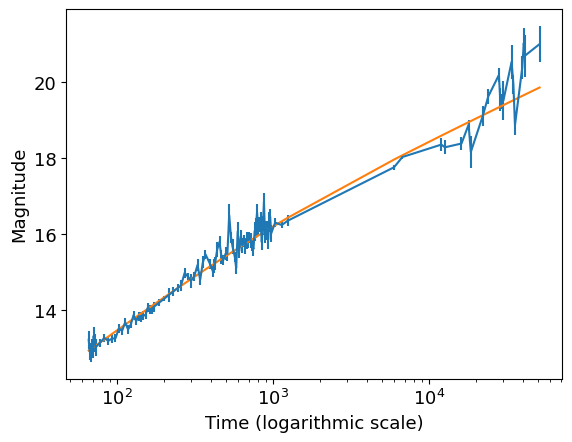

In [155]:
#given from instruction

ig = soln.x # the initial guess for the MCMC
# plot the model as it looks with the initial guess values
pl.errorbar(x, y, yerr=s)
#pl.plot(x, bpl(ig, x_nolog))
pl.plot(x, bpl(ig, x))
pl.xscale("log")
pl.xlabel('Time (logarithmic scale)')
pl.ylabel('Magnitude')
"""
X-axis shows: 10², 10³, 10⁴ (linear time values displayed on log scale)

The numbers represent actual time in seconds

The spacing is logarithmic, but the labels are linear values
"""

The plot shows a smooth broken power law curve for GRB agterglow with a clear break around Tb=980 seconds. The early steep decay  for t < Tb and  The later shallower decay  for t >Tb.  The curve starts around magnitude 15 at early times and rise to ~20 at late times

Text(0, 0.5, 'Magnitude')

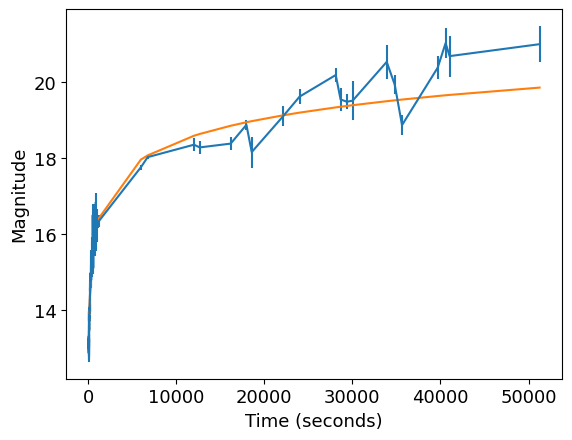

In [156]:
pl.errorbar(x, y, yerr=s)
pl.plot(x, bpl(ig, x))
# Remove: pl.xscale("log")  # See what it looks like in linear space
pl.xlabel('Time (seconds)')
pl.ylabel('Magnitude')

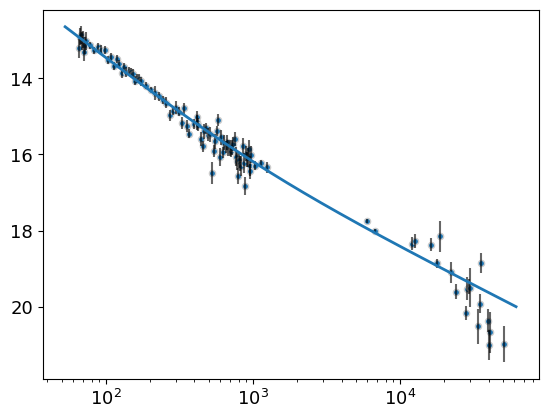

In [153]:
ig= soln.x
tt = np.logspace(np.log10(x.min()*0.8), np.log10(x.max()*1.2), 500)
plt.errorbar(x, y, yerr=s, fmt='.', ms=0, color='k', alpha=0.6)
plt.scatter(x, y, s=20, edgecolor='#ccc')
plt.plot(tt, bpl(ig, tt), lw=2)
plt.xscale('log'); plt.gca().invert_yaxis()
plt.show()


Text(0, 0.5, 'Magnitude')

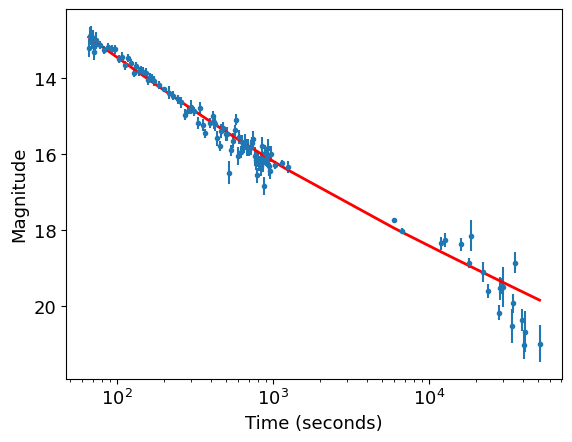

In [143]:
# Sort by time for clean plotting
sort_idx = np.argsort(x)
x_sorted = x[sort_idx]
y_sorted = y[sort_idx]
s_sorted = s[sort_idx]

pl.errorbar(x_sorted, y_sorted, yerr=s_sorted, fmt='o', markersize=3)
pl.plot(x_sorted, bpl(ig, x_sorted), 'r-', linewidth=2)
pl.xscale("log")
pl.yscale("linear")
pl.gca().invert_yaxis()  # Magnitude scale: brighter = smaller numbers
pl.xlabel('Time (seconds)')
pl.ylabel('Magnitude')

# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [177]:
# set the emcee hyperparameters for BPL
# Use the initial guess from the minimization
ig = soln.x

# set the number of dimensions and walkers for BPL
ndim = len(ig) # Should be 4 for BPL (a1, a2, b, Tb)
nwalkers = 32 # Or choose a suitable number, typically > 2*ndim

# the starting point for each walker is a small perturbation of the initial guess
pos = ig + 1e-4 * np.random.randn(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(x, y, s)) # Use log_posterior_bpl

In [178]:
# run the model
sampler.run_mcmc(pos, 1_000, progress=True);

100%|██████████| 1000/1000 [00:01<00:00, 625.46it/s]


In [179]:
samples = sampler.get_chain()

In [180]:
samples.shape

(1000, 32, 4)

In [182]:
# Test with just 10 steps to see if anything moves
sampler_test = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(x, y, s))
sampler_test.run_mcmc(pos, 10, progress=True)

# Check if any steps were accepted
print(f"Acceptance fraction: {np.mean(sampler_test.acceptance_fraction)}")

100%|██████████| 10/10 [00:00<00:00, 109.99it/s]

Acceptance fraction: 0.0


In [183]:
print("Initial positions (first 5 walkers):")
print(pos[:5])
print(f"Initial log-posterior values:")
for i in range(5):
    lp = log_posterior_bpl(pos[i], x, y, s)
    print(f"Walker {i}: {lp}")

Initial positions (first 5 walkers):
[[  2.99980162   1.97261037  16.45729217 972.46035658]
 [  2.99993835   1.97249847  16.45729735 972.46061726]
 [  2.99999618   1.97258603  16.45721139 972.46043947]
 [  3.0001001    1.97280184  16.45731528 972.46052673]
 [  3.00005646   1.97254562  16.45713667 972.46053234]]
Initial log-posterior values:
Walker 0: -inf
Walker 1: -inf
Walker 2: -inf
Walker 3: -inf
Walker 4: -inf


In [184]:
test_theta = pos[0]
print(f"Testing theta: {test_theta}")

# Check prior
lp = log_prior_bpl(test_theta)
print(f"Log prior: {lp}")

# Check likelihood
ll = log_likelihood_bpl(test_theta, x, y, s)
print(f"Log likelihood: {ll}")

# Check BPL model output
model_out = bpl(test_theta, x)
print(f"BPL model range: {model_out.min()} to {model_out.max()}")
print(f"BPL model finite: {np.all(np.isfinite(model_out))}")

Testing theta: [  2.99980162   1.97261037  16.45729217 972.46035658]
Log prior: -inf
Log likelihood: -233.20732852522818
BPL model range: 12.925973369986858 to 19.84655787436162
BPL model finite: True


In [186]:
# Update your functions temporarily
sampler_debug = emcee.EnsembleSampler(nwalkers, ndim,
                                     lambda theta, x, y, s: log_prior_bpl(theta) + log_likelihood_bpl(theta, x, y, s),
                                     args=(x, y, s))
sampler_debug.run_mcmc(pos, 100, progress=True)
print(f"Debug acceptance: {np.mean(sampler_debug.acceptance_fraction)}")

100%|██████████| 100/100 [00:00<00:00, 566.84it/s]

Debug acceptance: 0.0


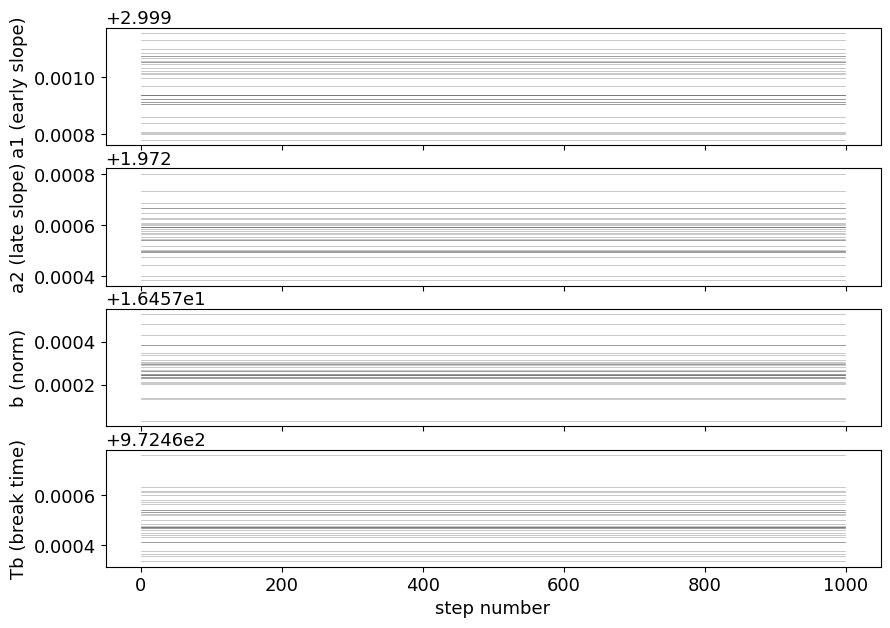

In [187]:
#plot the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

# Parameter labels for BPL model
param_labels = ["a1 (early slope)", "a2 (late slope)", "b (norm)", "Tb (break time)"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], 'k', alpha=0.3, lw=0.5)
    #ax.set_ylabel(f"Parameter {i}")
    ax.set_ylabel(param_labels[i])
axes[-1].set_xlabel("step number");

In [ ]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples = ...
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc[i] = ...
mcmc[:,1]

In [ ]:
#plot the BPL model
ax = plotlogtime(grbAG) # Keep plotting all data for context

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

# Plotting the MCMC BPL model
# Need to run the BPL MCMC first to get 'mcmc' for BPL
# For now, let's plot the initial guess BPL model
tt = np.logspace(np.log10(x.min()*0.8), np.log10(x.max()*1.2), 500) # Use original time range
ax.plot(np.log10(tt), bpl(ig, tt), lw=2, c='r', label='BPL Initial Guess')


# Optional: Plot the line models from previous steps for comparison if desired
# #plotting MCMC line model
# plotline((mcmc_line[0][1], mcmc_line[1][1]), grbAG.logtime.values,
#         ls="-", c="k",
#         label="MCMC line", ax=ax)

# #normal equation
# plotline((theta_best[1], theta_best[0]), grbAG.logtime.values,
#          color='#'+colors[0],  alpha=0.5,
#          label="Normal Equation", ax=ax)
# #sklearn
# plotline((lr.coef_[0], lr.intercept_), grbAG.logtime,
#          color='#'+colors[2], symbol='-',
#          label="sklearn LinearRegression", ax=ax)
# #minimize L1
# plotline((l1Solution.x[0], l1Solution.x[1]), grbAG.logtime,
#          symbol=':', alpha=0.5,
#          label="L1 minimization", ax=ax)
# #minimize L2
# plotline((l2Solution.x[0], l2Solution.x[1]), grbAG.logtime,
#          symbol='--', alpha=0.5,
#          label="L2 minimization", ax=ax)
# #minimize chi2
# plotline((chi2Solution.x[0], chi2Solution.x[1]), grbAG.logtime,
#          color='#'+colors[3], symbol='-.', alpha=0.5,
#          label=r"$\chi^2$ minimization", ax=ax)


pl.legend()

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

## plot the marginalized posterior distributions of the parameters

In [ ]:
pl.rcParams["font.size"]= 13
# Need to run the BPL MCMC first and get flat_samples_bpl and mcmc_bpl
# For now, this cell will not work correctly until BPL MCMC is run and results are stored in flat_samples_bpl and mcmc_bpl
# Assuming BPL MCMC results are stored in flat_samples_bpl and mcmc_bpl (median values in mcmc_bpl[:,1])
# fig = corner.corner(
#     flat_samples_bpl, labels=["a1", "a2", "b", "Tb"], truths=mcmc_bpl[:,1]);

# Placeholder to indicate this needs BPL MCMC results
print("Run the BPL MCMC and then update this cell to use flat_samples_bpl and mcmc_bpl")

EXTRA CREDIT FOR 461 REQUIRED FOR 661

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in https://slides.com/d/Ql12kB4/live#/11. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)


- implement the calculation of the likelihood ration, which is expected to be chisq distributed following a chisq distribution with k degrees of freedom where k is the difference in number of parameters.

- implement the caluculation of the AIC (https://slides.com/d/Ql12kB4/live#/11/6
- and BIC (https://slides.com/d/Ql12kB4/live#/11/8)



In [ ]:
print("..."... log_likelihood(mcmc_line[:,1], x, y, s)) #control the decimal digits!

In [ ]:
print("..."... log_likelihood_bpl(mcmc[:,1], x_nolog, y, s))

## Implement the likelihood ratio test printing out the likelihood ratio statistics https://slides.com/d/Ql12kB4/live#/11/2

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [ ]:
def like_ratio_statistics(...):
  return ...

# CHOOSE THE BEST MODEL IN THE NHRT FRAMEWORK


write out the first 4 steps of the NHRT:
- state the null
- state the alternative
- choose the threshold
- choose the test (OK, I did that for you!)
- measure the test statistics (pivotal quantity)
- get the p-value

_see if you can get the p-value from the table
I WILL NOT TAKE POINTS OFF IF YOU GET IT WRONG, but I want you to try and figure out how to read the table in https://slides.com/d/Ql12kB4/live#/11/2 to get a p-value out of your likelihood ratio statistics. Try your best!_

- use that p-value to see if you can or cannot reject the null and clearly state your conclusions



In [ ]:
.... #your work here

# your conclusions here

## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [ ]:
def aic(...):
  return


def bic(...):
  return


In [ ]:
print("AIC line {0:.2f} - AIC bpl {1:.2f}".format(aic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      aic(x, log_likelihood_bpl(mcmc[:,1], x_nolog, y, s), 4)))

print("BIC line {0:.2f} - BIC bpl {0:.2f}".format(bic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      bic(x, log_likelihood_bpl(mcmc[:,1], x_nolog, y, s), 4)))

# Extra Credit (Extra for everyone)
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model